## NIPS 2014 Late Review Observations

### Corinna Cortes and Neil D. Lawrence

### Updated for Python 3 Neil D. Lawrence 9th June 2021

This notebook analyzes the reduction in reviewer confidence between reviewers that submit their reviews early and those that arrive late. The reviews are first loaded in from files Corinna and Neil saved and stored in a pickle. The function for doing that is `nips.load_review_history`.


In [1]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

In [2]:
import cmtutils as cu
import cmtutils.nipsy as nipsy 
import cmtutils.plot as plot

import os
import pandas as pd
import numpy as np

In [3]:
reviews = nipsy.load_review_history()

## Review Submission Times

All reviews are now in pandas data frame called reviews, they are ready for processing. First of all, let's take a look at when the reviews were submitted. The function `nipsy.reviews_before` gives a snapshot of the reviews as they stood at a particular date. So we simply create a data series across the data range of reviews (`nipsy.review_data_range`) that shows the counts.

In [4]:
review_count = pd.Series(index=nipsy.review_date_range)
for date in nipsy.review_date_range:
    review_count.loc[date] = nipsy.reviews_before(reviews, date).Quality.shape[0]



In [5]:
import matplotlib.pyplot as plt
import mlai



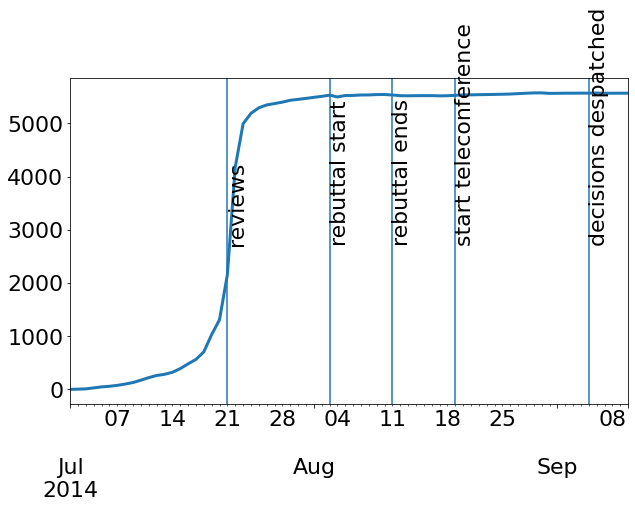

In [6]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
review_count.plot(linewidth=3, ax=ax)
plot.deadlines(ax)
mlai.write_figure(filename='review-count.svg', directory='neurips')

We worked hard to try and ensure that all papers had three reviews before the start of the rebuttal. This next plot shows the numbers of papers that had less than three reviews across the review period. First let's look at the overall statistics of what the count of reviewers per paper were. Below we plot mean, maximum, median and minimum over time.

In [7]:
lastseen = reviews.drop_duplicates(subset='ID').set_index('ID')
lastseen = lastseen['LastSeen']

review_count = pd.DataFrame(index=reviews.ID.unique(), columns=nipsy.review_date_range)
for date in nipsy.review_date_range:
    counts = nipsy.reviews_status(reviews, date, column='Quality').count(level='ID')
    review_count[date] = counts.fillna(0)
review_count.fillna(0, inplace=True)    
review_count = review_count.T
for col in review_count.columns:
    if pd.notnull(lastseen[col]):
        review_count[col][review_count.index>lastseen[col]] = np.NaN
        
review_count = review_count.T

In [8]:
import matplotlib.pyplot as plt
import mlai

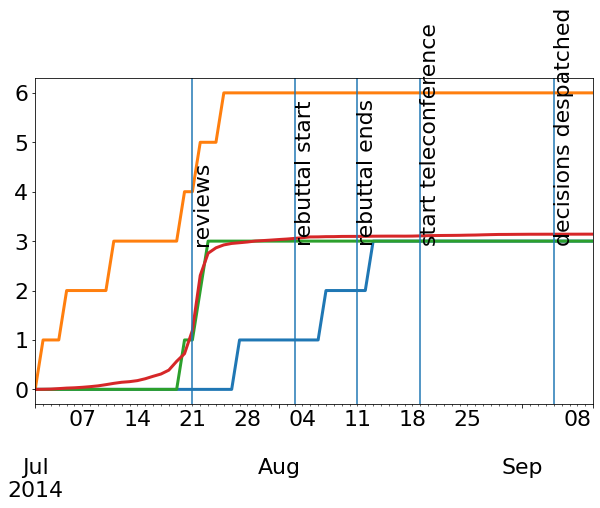

In [9]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
review_count.min().plot(linewidth=3, ax=ax)
review_count.max().plot(linewidth=3, ax=ax)
review_count.median().plot(linewidth=3, ax=ax)
review_count.mean().plot(linewidth=3, ax=ax)
plot.deadlines(ax)
mlai.write_figure(filename='number-of-reviews-over-time.svg', directory='neurips')

But perhaps the more important measure is how many papers had less than 3 reviewers over time. In this plot you can see that by the time rebuttal starts almost all papers have three reviewers.

In [10]:
count = pd.Series(index=nipsy.review_date_range)
for date in nipsy.review_date_range:
    count[date] = (review_count[date]<3).sum()

In [11]:
import matplotlib.pyplot as plt
import mlai

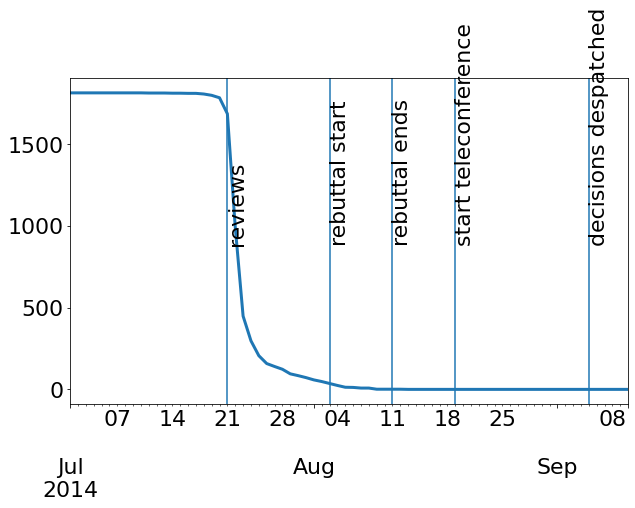

In [12]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
count.plot(linewidth=3, ax=ax)
plot.deadlines(ax)
mlai.write_figure(filename='paper-short-reviews.svg', directory='neurips')

## Review Confidence

Now we will check the confidence of reviews as the come in over time. We've written a small helper function that looks in a four day window around each time point and summarises the associated score (in the first case, confidence, `Conf`) with its across the four day window and 95% confidence intervals computed from the standard error of the mean estimate.

In [13]:
import matplotlib.pyplot as plt
import mlai

 /Users/neil/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:171: UserWarning:Warning: converting a masked element to nan.


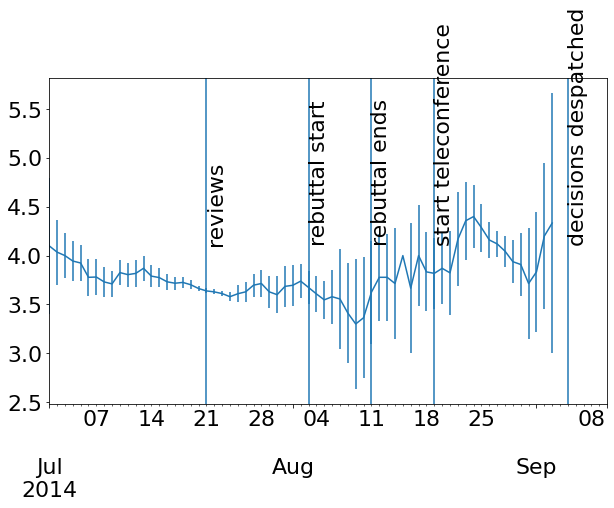

In [14]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.evolving_statistic(reviews, 'Conf', window=4, ax=ax)
mlai.write_figure(filename='review-confidence-time.svg', directory='neurips')

It looks like there might be a reduction in confidence as we pass the review deadline on 21st July, but is the difference in confidence for the reviews that came in later really significant? 

We now simplify the question by looking at the average confidence for reviews that arrived before 21st July (the reviewing deadline) and reviews that arrived after the 21st July (i.e. those that were chased or were allocated late) but before the rebuttal period started (4th August). Below we select these two groups and estimate the estimate of the mean confidence with (again with error bars).

On time reviewers Conf: 3.6819052178075635 +/- 0.025907038294118452
Chased reviewers Conf: 3.5942238267148015 +/- 0.04466378391551106
t-statistic is 3.3836648188800282 and p-value is 0.0007201959254345378


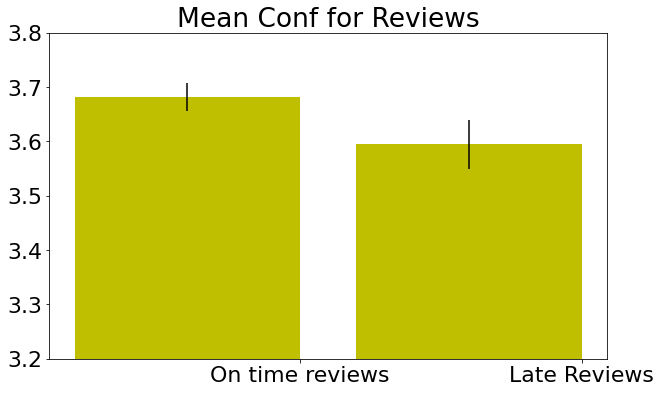

In [15]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
column = "Conf"
cat1, cat2 = nipsy.late_early_values(reviews, column)
plot.late_early(cat1, cat2, column=column, ylim=(3.2, 3.8), ax=ax)
mlai.write_figure(filename='review-confidence-early-late.svg', directory='neurips')

So it looks like there is a small but significant difference between the average confidence of the submitted reviews before and after the deadline, the statistical significance is confirmed with a $t$-test with a $p$-value at 0.048%. The magnitude of the difference is small (about 0.1) but may indicate a tendency for later reviewers to be a little more rushed.

# Quality Score

This begs the question, is there an effect on the other scores of their reviews which cover 'quality' and 'impact'. Quality of papers is scored on a 10 point scale with a recommendation of 6 being accept and We can form a similar plot for quality as follows.

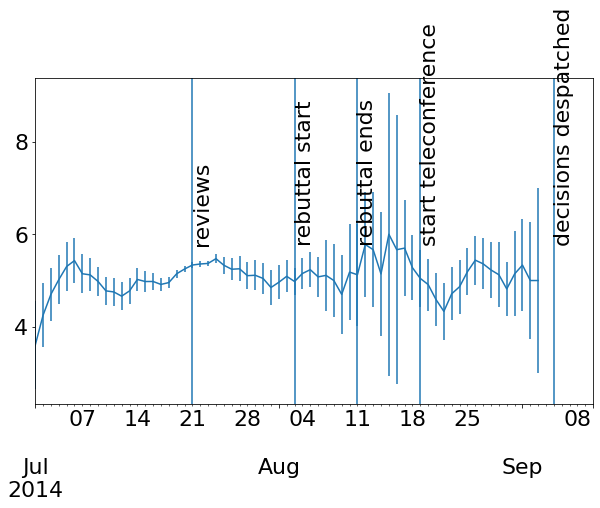

In [16]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.evolving_statistic(reviews, column='Quality', window=4, ax=ax)
mlai.write_figure(filename='review-quality-time.svg', directory='neurips')


On time reviewers Quality: 5.192915270464337 +/- 0.05499751801077536
Chased reviewers Quality: 5.4166064981949456 +/- 0.09366996093544587
t-statistic is -4.078413635776766 and p-value is 4.597764669734945e-05


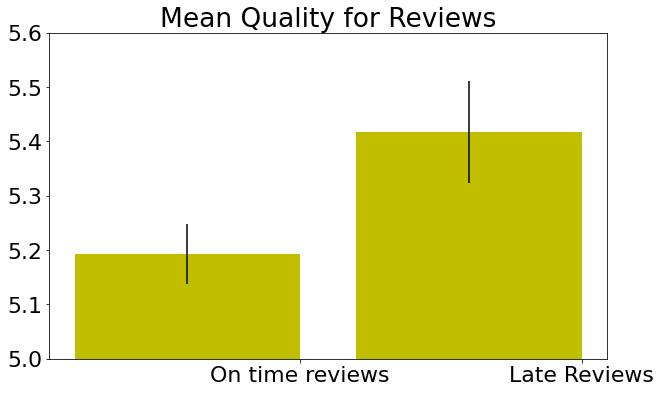

In [17]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
column = "Quality"
cat1, cat2 = nipsy.late_early_values(reviews, column)
plot.late_early(cat1, cat2, column=column, ylim=(5.0, 5.6), ax=ax)
mlai.write_figure(filename='review-quality-early-late.svg', directory='neurips')



There is another statistically significant difference between perceived quality scores after the reviewing deadline than before. On average reviewers tend to be more generous in their quality perceptions when the review is late. The $p$-value is computed as 0.007%. We can also check if there is a similar on the impact score. The impact score was introduced by Ghahramani and Welling in an effort to get reviewers not just to think about the technical side of the paper, but whether it is driving the field forward. The score is binary, with 1 being for a paper that is unlikey to have high impact and 2 being for a paper that is likely to have a high impact.

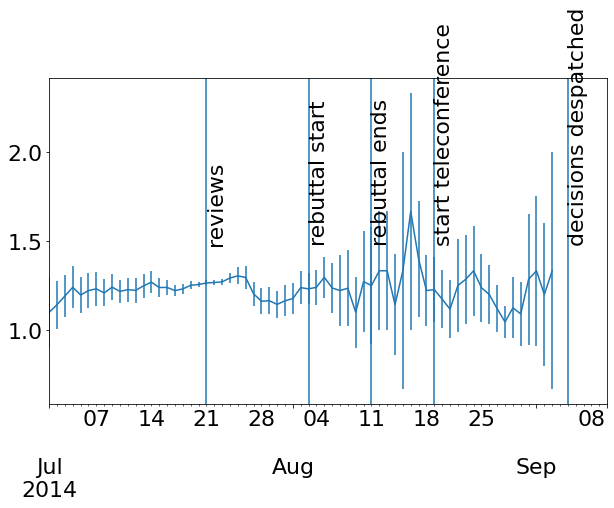

In [18]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.evolving_statistic(reviews, 'Impact', window=4, ax=ax)
mlai.write_figure(filename='review-impact-time.svg', directory='neurips')



On time reviewers Impact: 1.2515557683101963 +/- 0.013427483303543914
Chased reviewers Impact: 1.2779783393501805 +/- 0.024084772142156236
t-statistic is -1.9476649415584082 and p-value is 0.0515053234948586


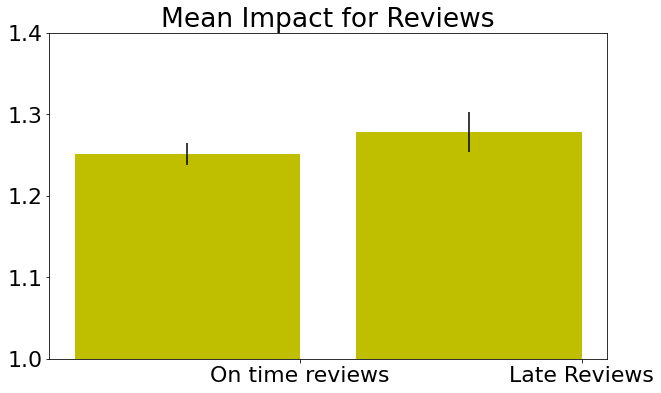

In [19]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
column = "Impact"
cat1, cat2 = nipsy.late_early_values(reviews, column)
plot.late_early(cat1, cat2, column=column, ylim=(1, 1.4), ax=ax)
mlai.write_figure(filename='review-impact-early-late.svg', directory='neurips')




We find the difference is not quite statistically significant for the impact score ($p$-value of 5.9%), but if anything there is a trend to have slightly higher impacts for later reviews.


# Review Length

A final potential indicator of review quality is the length of the reviews, we can check if there is a difference between the combined length of the review summary and the main body comments for late and early reviews. 

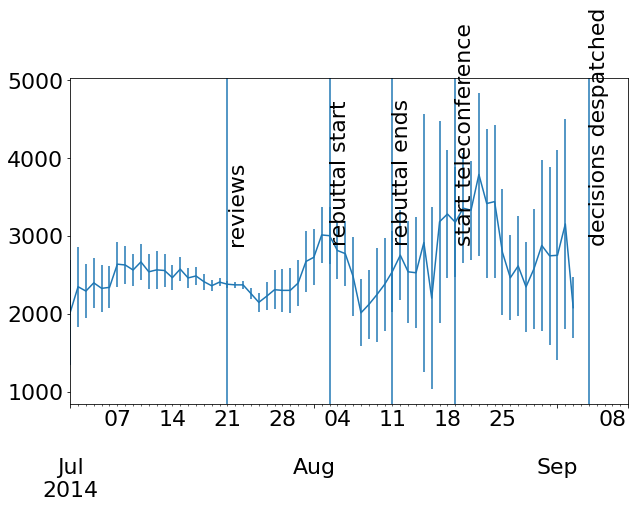

In [20]:
reviews['length'] = reviews['Comments'].apply(len) + reviews['Summary'].apply(len)
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
plot.evolving_statistic(reviews, 'length', window=4, ax=ax)
mlai.write_figure(filename='review-length-time.svg', directory='neurips')



On time reviewers length: 2422.321445667784 +/- 42.52996150833919
Chased reviewers length: 2304.8823104693142 +/- 71.83030761743862
t-statistic is 2.774458890805334 and p-value is 0.005547817842071767


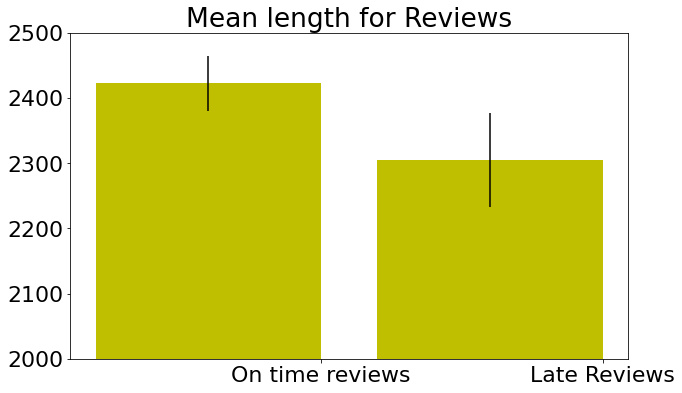

In [21]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
column = "length"
cat1, cat2 = nipsy.late_early_values(reviews, column)
plot.late_early(cat1, cat2, column=column, ylim=(2000, 2500), ax=ax)
mlai.write_figure(filename='review-length-early-late.svg', directory='neurips')

Once again we find a small but statitically significant difference, here, as we might expect late reviews are shorter than those submitted on time, by about 100 words in a 2,400 word review.

In [22]:
review_quality = pd.DataFrame(index=reviews.ID.unique(), columns=nipsy.review_date_range)
for date in nipsy.review_date_range:
    qual = nipsy.reviews_status(reviews, date, column='Quality')
    review_quality[date] = qual.sum(level='ID')/qual.count(level='ID') # There's a bug where mean doesn't work in Pandas 1.2.4??

In [23]:
original_pairs = pd.read_csv(os.path.join(nipsy.review_store, 'Duplicate_PaperID_Pairs.csv'), index_col='original')
duplicate_pairs = pd.read_csv(os.path.join(nipsy.review_store, 'Duplicate_PaperID_Pairs.csv'), index_col='duplicate')

Perform an 'inner join' on duplicate papers and their originals with their reviews, and set the index of the duplicated papers to match the original. This gives us data frames with matching indices containing scores over time of the duplicate and original papers.

In [24]:
duplicate_reviews = duplicate_pairs.join(review_quality, how="inner").set_index('original')
original_reviews = original_pairs.join(review_quality, how="inner")
del original_reviews["duplicate"]

In [25]:
corr_series = duplicate_reviews.corrwith(original_reviews)
corr_series.index = pd.to_datetime(corr_series.index)


In [26]:
def bootstrap_index(df):
    n = len(df.index)
    return df.index[np.random.randint(n, size=n)]

In [27]:
bootstrap_corr_df = pd.DataFrame(index=corr_series.index)
for i in range(1000):
    ind = bootstrap_index(original_reviews)
    b_corr_series = duplicate_reviews.loc[ind].corrwith(original_reviews.loc[ind])
    b_corr_series.index = pd.to_datetime(b_corr_series.index)
    bootstrap_corr_df[i] = b_corr_series

In [28]:
import datetime as dt

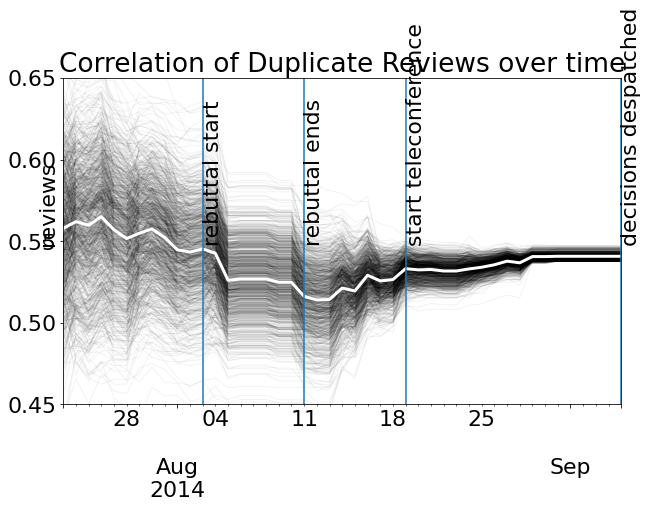

In [29]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
final_vals = bootstrap_corr_df.loc[bootstrap_corr_df.index.max()]
total_mean = final_vals.mean()
(bootstrap_corr_df - final_vals+total_mean).plot(legend=False, ax=ax, linewidth=1, alpha=0.05, color='k')
corr_series.plot(ax=ax, linewidth=3, color="w")
ax.set_ylim(0.45, 0.65)
ax.set_xlim(dt.datetime(2014,7,23),nipsy.events['decisions_despatched'])
ax.set_title("Correlation of Duplicate Reviews over time")

plot.deadlines(ax)
mlai.write_figure(filename='correlation-duplicate-reviews-bootstrap.svg', directory='neurips')


Plot the correlation of the duplicated papers over time (do bootstrap samples here??)

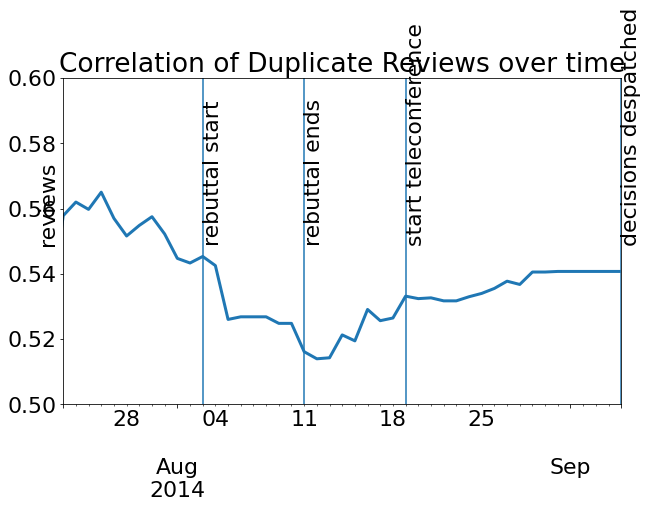

In [30]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)
#
import datetime as dt
corr_series.plot(ax=ax, linewidth=3)
ax.set_ylim(0.5, 0.6)
ax.set_xlim(dt.datetime(2014,7,23),nipsy.events['decisions_despatched'])
ax.set_title("Correlation of Duplicate Reviews over time")

plot.deadlines(ax)
mlai.write_figure(filename='correlation-duplicate-reviews.svg', directory='neurips')

We need to do a bit more analysis on the estimation of the correlation for the earlier submissions, but from what we see above, it looks like the correlation is being damaged by late reviews, and we never quite recover the consistency of reviews we had at the submission deadline even after the discussion phase is over.

## Summary

In summary we find that late reviews are on average less confident and shorter, but rate papers as higher quality and perhaps as higher impact. Each of the effects is small (around 5%) but overall a picture emerges of a different category of review from those that delay their assesment.